<h1 align='center'>EE2703 Applied Programming Lab</h1>
<h2 align='center'>Assignment 8</h2>
<h3 align='center'>March 31, 2018</h3>
<h3 align='center'>Rajat Vadiraj Dwaraknath EE16B033</h3>

# Introduction
In this assignment, we use Sympy to analytically solve a matrix equation governing an analog circuit. We look at two circuits, an active low pass filter and an active high pass filter. We create matrices using node equations for the circuits in sympy, and then solve the equations analytically. We then convert the resulting sympy solution into a numpy function which can be called. We then use the signals toolbox we studied in the last assignment to understand the responses of the two circuits to various inputs.

In [1]:
%%capture
# Importing numpy and matplotlib
%pylab inline 
from IPython.display import *
import writefile_run

In [2]:
# Increase figure and font size
rcParams['figure.figsize'] = 18,6
rcParams['font.size'] = 18
rcParams['text.usetex'] = True

In [3]:
%%capture
%%writefile_run ee16b033_8.py -dr

import sys
import argparse
from pylab import *
from IPython.display import *

"""
Get command line arguments and assign them to variables automatically.
"""

ARGS = {}

def addargs(args,parser):
    for arg in args:
        parser.add_argument('-{}'.format(arg),default=args[arg],type=type(args[arg]))
        
ap = argparse.ArgumentParser()
addargs(ARGS,ap)
args = ap.parse_args()

for arg in ARGS:
    exec("{} = args.{}".format(arg,arg))
    

# Low pass filter circuit
We create a function to solve the low pass active filter circuit given in the assignment question as the first figure.

In [4]:
%%writefile_run ee16b033_8.py -a

from sympy import *
import scipy.signal as sp

H,s=symbols('H(s) s')
init_printing()

def lowpass(R1=10e3,R2=10e3,C1=1e-9,C2=1e-9,G=1.586,Vi=1):
    """Solve the given lowpass filter circuit for a given input Vi."""
    A=Matrix([[0,0,1,-1/G],
              [-1/(1+s*R2*C2),1,0,0],
              [0,-G,G,1],
              [-1/R1-1/R2-s*C1,1/R2,0,s*C1]])
    
    b=Matrix([0,0,0,-Vi/R1])
    
    V=A.inv()*b
    return (A,b,V)

A helper function to graph the bode plots of an arbitrary sympy expression in $s$ is written below:

In [5]:
%%writefile_run ee16b033_8.py -a


def bodePlot(H_s,w_range=(0,8),points=800):
    """Plot the magnitude and phase of H_s over the given range of frequencies."""
    
    w = logspace(*w_range,points)
    h_s = lambdify(s,H_s,'numpy')
    H_jw = h_s(1j*w)
    
    # find mag and phase
    mag = 20*np.log10(np.abs(H_jw))
    phase = angle(H_jw,deg = True)
    
    eqn = Eq(H,simplify(H_s))
    display(eqn)
    
    fig,axes = plt.subplots(1,2,figsize=(18,6))
    ax1,ax2 = axes[0],axes[1]
    
    # mag plot
    ax1.set_xscale('log')
    ax1.set_ylabel('Magntiude in dB')
    ax1.set_xlabel('$\omega$ in rad/s')
    ax1.plot(w,mag)
    ax1.grid()
    ax1.set_title("Magnitude of $H(j \omega)$")
    
    # phase plot
    ax2.set_ylabel('Phase in degrees')
    ax2.set_xlabel('$\omega$ in rad/s')
    ax2.set_xscale('log')
    ax2.plot(w,phase)
    ax2.grid()
    ax2.set_title("Phase of $H(j \omega)$")
    
    plt.show()

The bode plots of the low pass filter transfer function, along with the analytical expression of the transfer function are shown below:

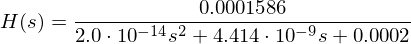

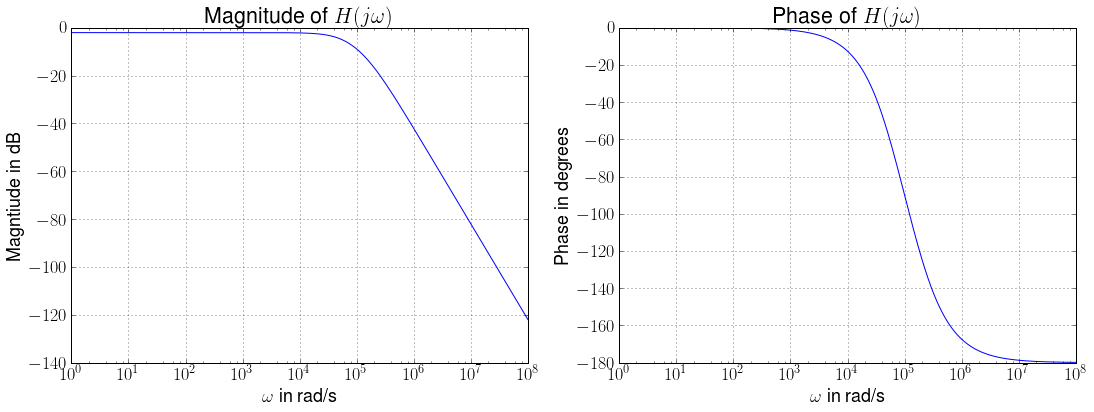

In [6]:
%%writefile_run ee16b033_8.py -a


A,b,V=lowpass()
Vo = V[3]
bodePlot(Vo)

We observe that the gain rolls off at $-40$ dB per decade after the cutoff frequency of around $10^5$ rad/s. The phase also changes directly from an initial value of $180$ degrees to a final value of $0$ degrees. This means that the filter is a second order filter. Since the phase starts of at $0$ degrees, this filter is a non-inverting low pass filter. Also note that the DC gain is approximately $0.793$.

Let us analyze the system in terms of its quality factor.

A function to convert a rational polynomial sympy expression into a tuple of numerator and denominator coefficients is written below:

In [7]:
%%writefile_run ee16b033_8.py -a


def symToTransferFn(Y_s):
    """
    Convert a sympy rational polynomial into one that can be used for scipy.signal.lti.
    
    Returns a tuple (num,den) which contains the coefficients of s of
    the numerator and denominator polynomials.
    """
    
    # get the polynomial coefficients after simplification
    Y_ss = expand(simplify(Y_s))
    n,d = fraction(Y_ss)
    n,d = Poly(n,s), Poly(d,s)
    num,den = n.all_coeffs(), d.all_coeffs()
    num,den = [float(f) for f in num], [float(f) for f in den]

    return num,den

A function to find the Q factor of a second order system is written below:

In [8]:
%%writefile_run ee16b033_8.py -a


def findQ(H_s):
    """Find the quality factor of the input transfer function assuming it is second order."""
    nl,dl = symToTransferFn(H_s)
    syst = sp.lti(nl,dl)
    p1,p2 = syst.poles[0], syst.poles[1]
    return np.sqrt(abs(p1*p2))/abs(p1+p2)

In [9]:
%%writefile_run ee16b033_8.py -a


print("Q factor of low pass filter: {:.4f}".format(findQ(lowpass()[-1][-1])))

Q factor of low pass filter: 0.4531


With a Q factor of approximately $0.45$ which is quite close to half, we can conclude that the filter is almost critically damped. This means that it has a very fast response time as the transients in its output die off as fast as possible.

# High pass filter circuit
We now repeat the process but for the high pass filter circuit given as the last figure in the assignment question pdf. Note that the signs of the gain block are incorrectly written in the question pdf, so they are switched in the subsequent analysis. The feedback path through the two resistors $(G-1)R$ and $R$ connects to the negative terminal of the gain block. To solve the circuit, we combine the node equations at nodes $V_1$, $V_p$ and $V_n$ along with the output equation of the differential gain block into one matrix equation below:

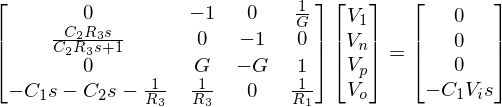

In [10]:
R1, R3, C1, C2, G, Vi = symbols('R_1 R_3 C_1 C_2 G V_i')

V1,Vn,Vp,Vo = symbols('V_1 V_n V_p V_o')
x=Matrix([V1,Vn,Vp,Vo])

A=Matrix([[0,-1,0,1/G],
        [s*C2*R3/(s*C2*R3+1),0,-1,0],
        [0,G,-G,1],
        [-s*C2-1/R3-s*C1,1/R3,0,1/R1]])

b=Matrix([0,0,0,-Vi*s*C1])

display(Eq(MatMul(A,x),b))

We now define a function to analytically solve this equation in sympy:

In [11]:
%%writefile_run ee16b033_8.py -a


#G1 = symbols('G1')
def highpass(R1=10e3,R3=10e3,C1=1e-9,C2=1e-9,G=1.586,Vi=1):
    """Solve the given highpass filter circuit for a given input Vi."""
    
    A=Matrix([[0,-1,0,1/G],
        [s*C2*R3/(s*C2*R3+1),0,-1,0],
        [0,G,-G,1],
        [-s*C2-1/R3-s*C1,1/R3,0,1/R1]])

    b=Matrix([0,0,0,-Vi*s*C1])

    V=A.inv()*b
    #V_lim = [limit(v,G1,oo) for v in V]
    return (A,b,V)

The bode plots of the transfer function and its analytical expression are shown below:

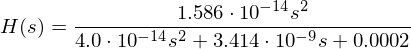

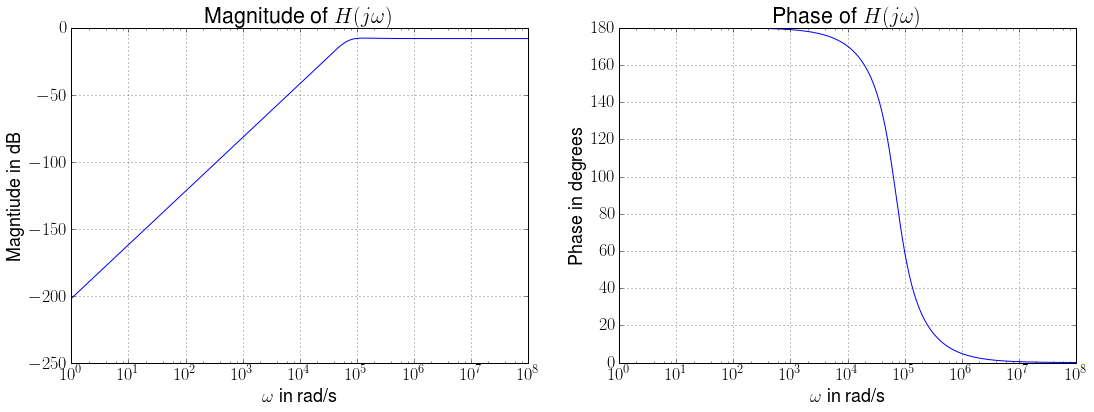

In [12]:
%%writefile_run ee16b033_8.py -a


A,b,V = highpass()
V_highpass =simplify(V[3])
bodePlot(V_highpass)

We observe from the gain plot that the gain rolls off at $+40$ dB per decade before the cutoff frequency of around $10^5$ rad/s. This means that it is second order high pass filter. Since the phase at very high frequencies is approximately $0$ degrees, this circuit is a non-inverting high pass filter.

In [13]:
%%writefile_run ee16b033_8.py -a


print("Q factor of high pass filter: {:.4f}".format(findQ(highpass()[-1][-1])))

Q factor of high pass filter: 0.8285


With a Q factor of approximately $0.82$ which is quite close to $\frac{1}{\sqrt 2} \approx 0.707$, we can conclude that the filter is close to being maximally flat. This means that it has as flat a pass band as possible after the gain roll off which occurs before the cutoff frequency.

# Responses to inputs
We find the responses of the above two filter circuits to various inputs by converting the sympy expressions to numpy functions using **lambdify**. We then use the signals toolbox to find the response in the time domain.

A function to find the causal inverse laplace transform of a sympy expression using **scipy.signal.impulse** is written below:

In [14]:
%%writefile_run ee16b033_8.py -a


def inverseLaplace(Y_s,t=None):
    """
    Finds the inverse laplace transform of a sympy expression using sp.impulse. 
    """
    
    # load the step response as a system in scipy.signal
    num,den = symToTransferFn(Y_s)
    
    # evaluate in time domain
    t,y = sp.impulse((num,den),T=t)
    return t,y

A function to plot the time domain responses of the two filter circuits to an arbitrary input specified in either the Laplace domain or the time domain is written below:

In [15]:
%%writefile_run ee16b033_8.py -a


def plotFilterOutputs(laplace_in=None, time_domain_fn=None, 
                      lp_range=(0,1e-3), hp_range=(0,1e-3), points=1e3,
                     input_name="Input"):
    """
    Plot the time domain outputs of the two active filters to a given input in the 
    laplace domain or the time domain.
    """
    
    t_lp = linspace(*lp_range,points)
    t_hp = linspace(*hp_range,points)

    
    if laplace_in != None:
        
        A,b,V_lowpass = lowpass(Vi=laplace_in)
        t_lp,y_lp = inverseLaplace(V_lowpass[-1],t=t_lp)
        
        
        A,b,V_highpass = highpass(Vi=laplace_in)
        t_hp,y_hp = inverseLaplace(V_highpass[-1],t=t_hp)
        
    elif time_domain_fn != None:
        
        A,b,V_lowpass = lowpass()
        lowsys = symToTransferFn(V_lowpass[-1])
        t_lp,y_lp,svec = sp.lsim(lowsys, time_domain_fn(t_lp), t_lp)
        
         
        A,b,V_highpass = highpass()
        highsys = symToTransferFn(V_highpass[-1])
        t_hp,y_hp,svec = sp.lsim(highsys, time_domain_fn(t_hp), t_hp)
    
    else:
        print("No input given.")
        
     
    fig,axes = plt.subplots(1,2,figsize=(18,6))
    ax1,ax2 = axes[0],axes[1]
    
    # low pass response plot
    ax1.set_ylabel('$V_o$')
    ax1.set_xlabel('$t$')
    ax1.plot(t_lp,y_lp)
    ax1.grid()
    ax1.set_title("Response of low pass filter to {}".format(input_name))
    
    # high pass response plot
    ax2.set_ylabel('$V_o$')
    ax2.set_xlabel('$t$')
    ax2.plot(t_hp,y_hp)
    ax2.grid()
    ax2.set_title("Response of high pass filter to {}".format(input_name))
   
    plt.show()
    return t_lp,y_lp, t_hp,y_hp

## Step response
We plot the outputs of the two systems to a unit step below:

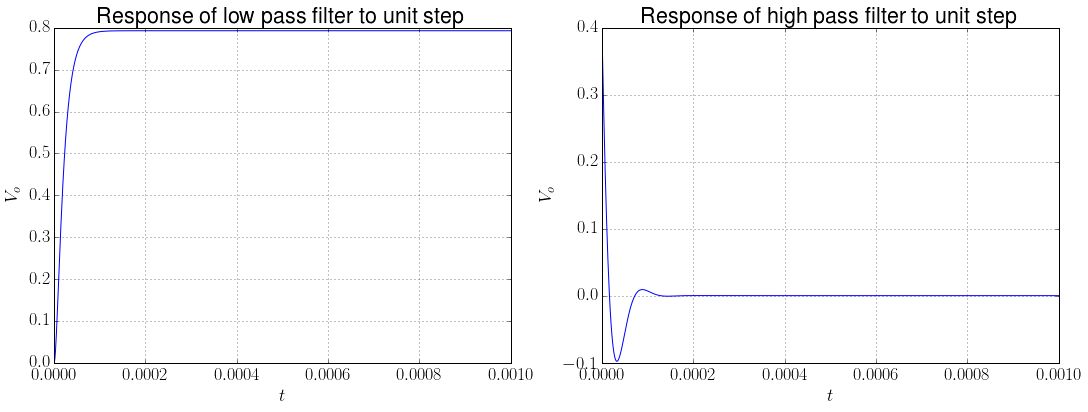

Steady state value of low pass filter step response: 0.7930
Steady state value of high pass filter step response: 0.0000


In [16]:
%%writefile_run ee16b033_8.py -a


t_lp,y_lp, t_hp,y_hp = plotFilterOutputs(laplace_in=1/s,input_name="unit step")
print("Steady state value of low pass filter step response: {:.4f}".format(y_lp[-1]))
print("Steady state value of high pass filter step response: {:.4f}".format(y_hp[-1]))

* We observe that the low pass filter inverts the step and attenuates it by a factor of $0.793$. This is indeed what we expect as we noticed earlier that the DC gain of the transfer function is indeed $0.793$. We observe a transient which decays quite fast, again as we expected as the system is almost critically damped.
* The transient of the high pass response is also similar. However, the steady state response of the high pass filter to the step is $0$. This is because it only allows frequencies higher than the cutoff to pass through attenuated. Since DC inputs have a frequency of $0$, it is completely filtered out. This is similar to what is done when two systems are coupled for AC signals.

## Sum of low and high frequency sinusoids
We analyse the responses to the following input:

$$v_i(t) = (\sin(2000 \pi t) + \cos(2 \times 10^6 \pi t))u(t)$$

In [17]:
%%writefile_run ee16b033_8.py -a


def vi1(t):
    """Sum of low frequency and high frequency sinusoids"""
    u_t = 1*(t>0)
    return (np.sin(2000*np.pi*t)+np.cos(2e6*np.pi*t)) * u_t

The input waveform is plotted below:

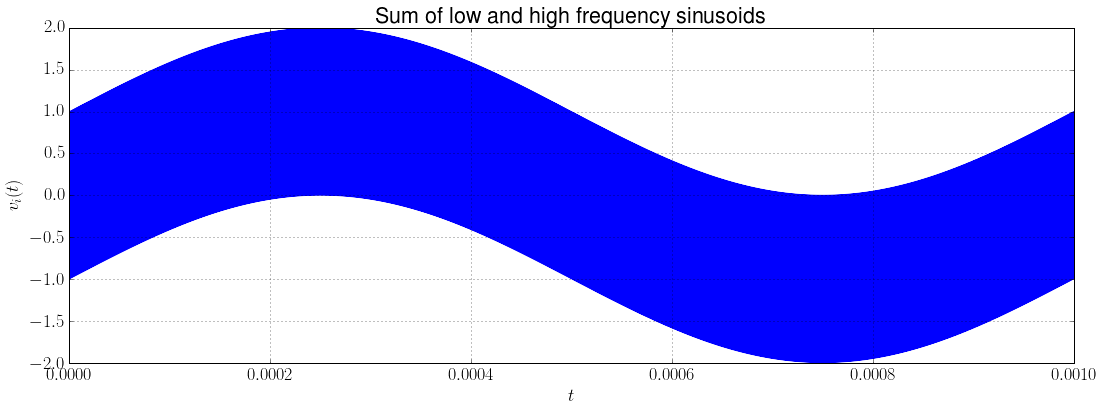

In [18]:
%%writefile_run ee16b033_8.py -a


t = linspace(0,1e-3,1e5)
plt.title("Sum of low and high frequency sinusoids")
plt.xlabel("$t$")
plt.ylabel("$v_i(t)$")
plt.plot(t,vi1(t))
plt.grid()
plt.show()

We first plot the response of the low pass filter in a very short time range and the high pass filter in a very large time range.

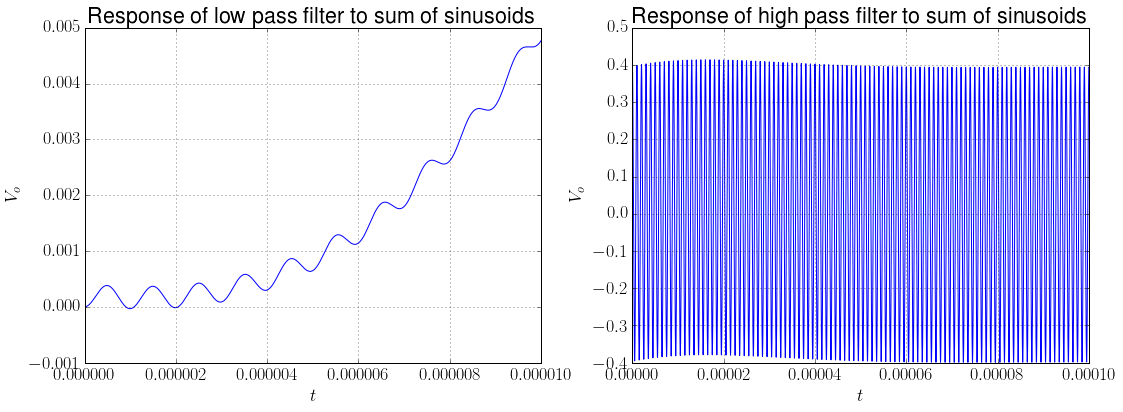

In [19]:
%%writefile_run ee16b033_8.py -a


a = plotFilterOutputs(time_domain_fn=vi1,input_name="sum of sinusoids",points=1e5,hp_range=(0,1e-4),lp_range=(0,1e-5))

* These time ranges allow us to notice the heavily attenuated part of the input better. We can see that an extremely low amplitude high frequency sinusoid rides on top of a slow response in the output of the low pass filter. This is because the low pass filter has heavily attentuated the high frequency component.
* Similaraly, in the high pass filter, a heavily attenuated low frequency sinusoid modulates a high frequency sinusoid. This is because the high pass filter highly attenuated the low frequency component.

Let us plot the low pass filter response on a larger time scale and the high pass filter response on a smaller time scale:

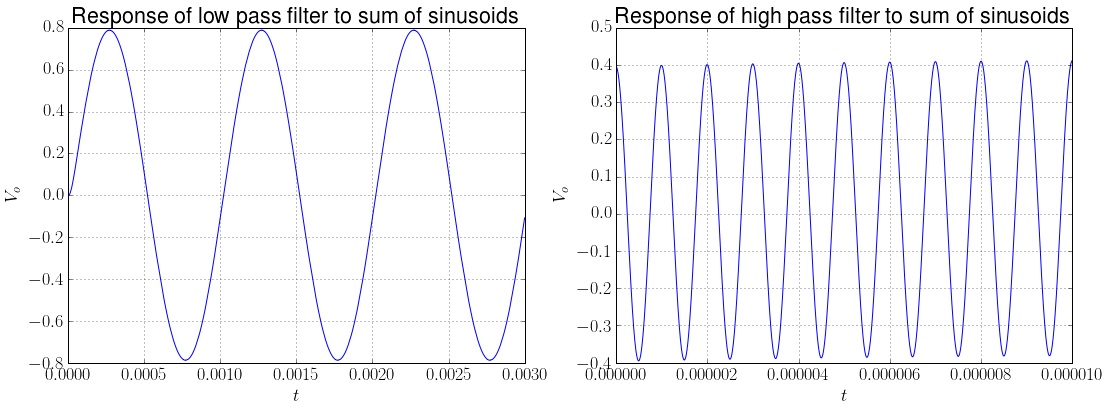

In [20]:
%%writefile_run ee16b033_8.py -a


a = plotFilterOutputs(time_domain_fn=vi1,input_name="sum of sinusoids",points=1e5,hp_range=(0,1e-5),lp_range=(0,3e-3))

* We observe that the low pass response more or less looks like a pure sinusoid of the lower frequency with the high frequency completely attenuated.
* We observe that the high pass response also looks like a pure sinusoid of the higher frequency with the low frequency completely attenuated.

## High frequency damped sinusoid
We analyse the outputs to a high frequency damped sinusoid given as:

$$v_i(t) = \cos(10^7 t) e^{-3000t} u(t)$$

In [21]:
%%writefile_run ee16b033_8.py -a


def input_f(t,decay=0.5,freq=1.5):
    """Exponentially decaying cosine function."""
    u_t = 1*(t>0)
    return np.cos(freq*t)*np.exp(-decay*t) * u_t

The input waveform is plotted below:

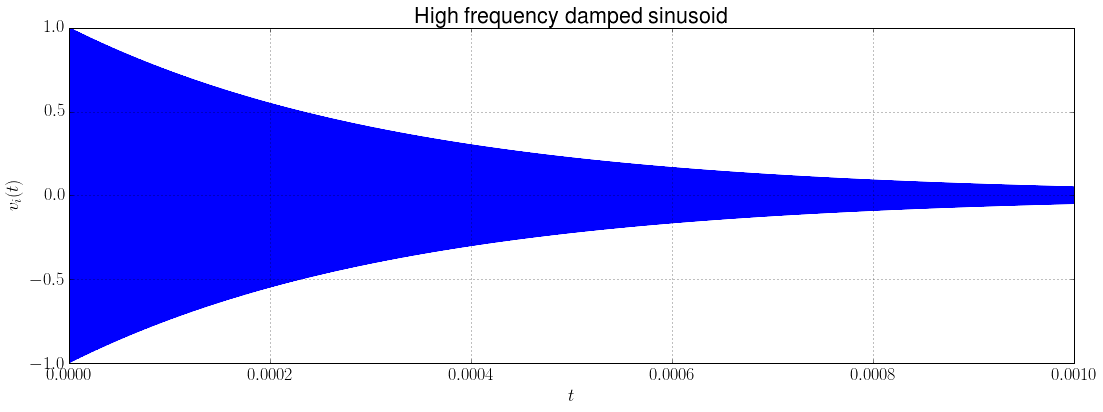

In [22]:
%%writefile_run ee16b033_8.py -a


t = linspace(0,1e-3,1e5)
plt.title("High frequency damped sinusoid")
plt.xlabel("$t$")
plt.ylabel("$v_i(t)$")
plt.plot(t,input_f(t,decay=3e3,freq=1e7))
plt.grid()
plt.show()

The responses are plotted below:

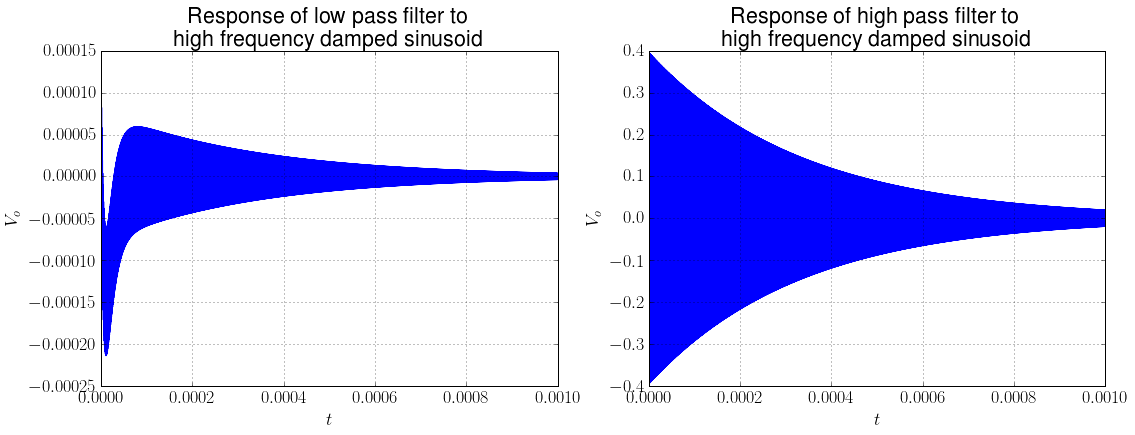

In [23]:
%%writefile_run ee16b033_8.py -a


a = plotFilterOutputs(time_domain_fn=lambda t:input_f(t,decay=3e3,freq=1e7),points=1e5
                  ,input_name='\nhigh frequency damped sinusoid')

* The low pass filter responds fast and attenuates the high frequency sinusoid. The output decays as the input also decays.
* The high pass filter responds by more or less letting the input pass through as is, without any extra attenuation. So the output decays as the input does.

## Low frequency damped sinusoid
We analyse the outputs to a high frequency damped sinusoid given as:

$$v_i(t) = \cos(10^3 t) e^{-10t} u(t)$$

The input waveform is plotted below:

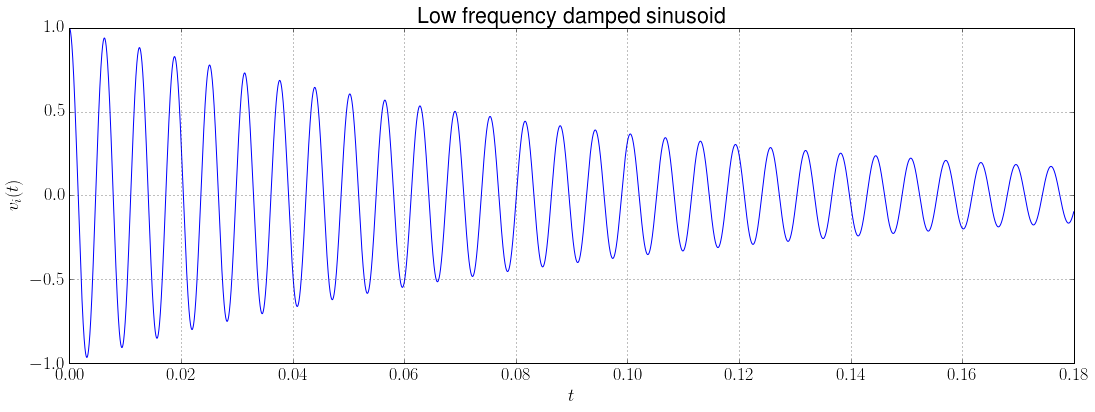

In [24]:
%%writefile_run ee16b033_8.py -a


t = linspace(0,1.8e-1,1e5)
plt.title("Low frequency damped sinusoid")
plt.xlabel("$t$")
plt.ylabel("$v_i(t)$")
plt.plot(t,input_f(t,decay=1e1,freq=1e3))
plt.grid()
plt.show()

The responses are plotted below:

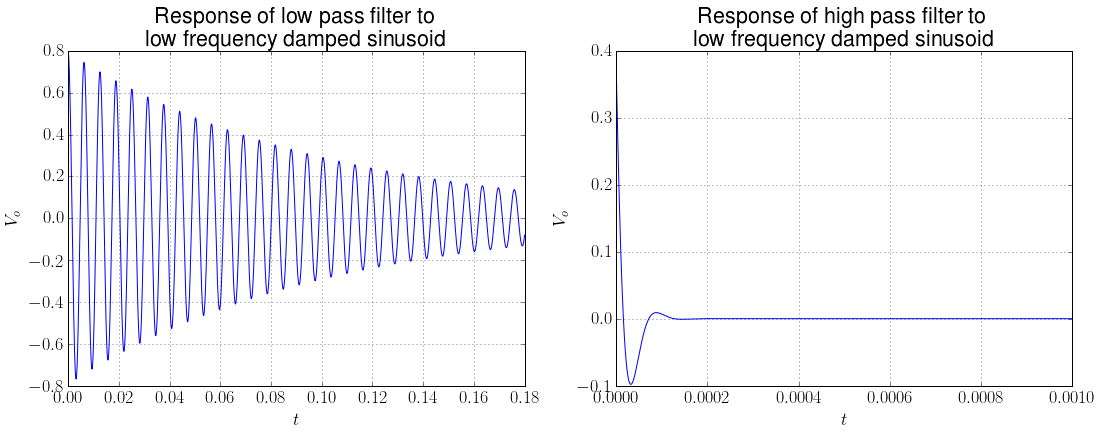

In [25]:
%%writefile_run ee16b033_8.py -a


a=plotFilterOutputs(time_domain_fn=lambda t:input_f(t,decay=1e1,freq=1e3),lp_range=(0,1.8e-1),points=1e5
                  ,input_name='\nlow frequency damped sinusoid')

# Conclusions

* The low pass filter responds by letting the low frequency sinusoid pass through without much additional attenuation. The output decays as the input also decays.
* The high pass filter responds by quickly attenuating the input. Notice that the time scales show that the high pass filter response is orders of magnitudes faster than the low pass response. This is because the input frequency is below the cutoff frequency, so the output goes to $0$ very fast.
* In conclusion, the sympy module has allowed us to analyse quite complicated circuits by analytically solving their node equations. We then interpreted the solutions by plotting time domain responses using the signals toolbox. Thus, sympy combined with the scipy.signal module is a very useful toolbox for analyzing complicated systems like the active filters in this assignment.